<a id="Title"></a>
# <span style="color:teal;font-weight:bold;">Spaceship Titanic 💡 Feature engineering</span>

This notebook is the second part of my <span style="font-weight:bold;color:green">Spaceship Titanic series</span>:

1. <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-getting-familiar/edit/run/191353629">Spaceship Titanic 🏁 Getting familiar</a>.
2. <span style="font-weight:bold">Spaceship Titanic 💡 Feature engineering.</span> [This notebook]
3. Spaceship Titanic 🩹 Data imputation. (Coming soon)
4. Spaceship Titanic 🖥️ Model optimization. (Coming soon)
5. Spaceship Titanic 🔭 Integrated analysis. (Coming soon)

Previously, I got a clear picture of the scoring expectation for this competition by studying the LeaderBoard and trying simple Machine Learning models with minimally edited data. From that experience, I learned that scoring above 0.80 are pretty good, but <span style="font-weight:bold;">my aim is getting a score above 0.81, looking for a place among the top 5% submissions</span>.

<span style="font-weight:bold;">In this notebook, I focus on feature engineering and see the scoring improvement using simple models.</span> 

In the future notebooks, I'll fix the missing values with data imputation techniques, optimize the Machine Learning model and finally make an integrated analysis based on my results and a deep study of other kagglers' contributions.

The methodology of this work is based on my previous notebook <a href="https://www.kaggle.com/code/fertmeneses/titanic-kaggle-full-analysis">Titanic/Kaggle -Full analysis</a> from the <span style="font-style:italic;">Titanic - Machine Learning from Disaster</span> competition.

<hr>

# <font color='teal'>Outline</font> <a class="anchor"  id="Outline"></a>

[**Data analysis**](#Data_analysis)

  - [Load original data](#Data_analysis_load)
  
  - [Distribution of values and transported rates](#Data_analysis_values_rates)
  
  - [Correlations I (original data)](#Data_analysis_correlations)
  
[**Feature engineering**](#Feature_engineering)

  - [Original single features](#Feature_engineering_single)

    - ["PassengerId": new feature "GroupMembers"](#DA_FE_GroupMembers)
   
    - ["CryoSleep": make boolean](#DA_FE_CryoSleep)
   
    - ["Cabin": new features "Cabin_1st" and "Cabin_isP"](#DA_FE_Cabin)
    
    - ["Destination" redefinition](#DA_FE_Destination)
   
    - ["VIP": make boolean](#DA_FE_VIP)
   
    - [Expense features redefinition](#DA_FE_Expenses_redefinition)
   
    - [Expense features: new features "X_Range"](#DA_FE_Expense_Range)
   
    - ["Name" feature: new feature "Ocurrence_LastName"](#DA_FE_Name)
   
    - [Correlations II (original and single engineered features)](#Feature_engineering_single_corr)
   
  - [Combined features](#Feature_engineering_combined)

    - ["FromTo" new feature (from "HomePlanet" and "Destination")](#DA_FE_FromTo)
   
    - [Expense-related new family of features (from "ExpFC", "ExpSM", "ExpRS", "ExpSpa" and "ExpVR")](#DA_FE_Expense_ratio)
   
    - [Correlations III (all features)](#Feature_engineering_corr3)
   
[**Submission results**](#Submission_results)
  
[**Conclusions**](#Conclusions)

<a id="Data_analysis"></a>
# <span style="color:teal;font-weight:bold;">Data analysis</span>

In this section, I load the original data and analyze it without any edition. This is the workflow:

- Load raw data.

- Analyze distribution of values and <span style="font-weight:bold;">Transported</span> rates.

- Analyze correlations. <span style="font-style:italic;">Note: for this step, I make a copy of the original dataset and One-Hot encode some features, but I don't use this copy for anything else.</span>

<a id="Data_analysis_load"></a>
## <span style="color:teal;font-weight:bold;">Load original data</span>

In the following lines, I load the original datasets and get this information:

- Example for 5 first rows in training dataset.

- Number of rows in both datasets.

- Features' names and data types.

- Number of missing values in both datasets, per feature and per row.

In [1]:
import pandas as pd
from termcolor import colored

# Load original datasets:
train_df = pd.read_csv('kaggle/input/spaceship-titanic/train.csv') # Training dataset
test_df = pd.read_csv('kaggle/input/spaceship-titanic/test.csv') # Testing dataset
# Keep the passengerID features separately:
train_ID = train_df['PassengerId']
test_ID = test_df['PassengerId']
# Display a few examples:
display(train_df.head(5)) # Examples
# Print global information:
print('\nNumber of rows in train/test datasets:\n')
print(len(train_df),'/',len(test_df))
print('\nFeatures: names and data types:\n')
print(train_df.dtypes)
# Print number of missing values per feature:
print('\nMissing values in train/test datasets:\n')
for col in test_df.columns:
    # Count missing values:
    N_train = train_df[col].isna().sum() 
    N_test = test_df[col].isna().sum()
    # Print results:
    color_train = 'red' if N_train else 'green'
    color_test = 'red' if N_test else 'green'
    rmargin = 40-len(col)
    print(f'{col}:',f'{colored(N_train, color_train)}/{colored(N_test, color_test)}'.rjust(rmargin))
# Count missing values in each row:
N_nan_train = train_df.apply(lambda x: x.isna().sum(), axis=1)
N_nan_test = test_df.apply(lambda x: x.isna().sum(), axis=1) 
# Print number of rows with N missing values:
for n in set(N_nan_train).union(set(N_nan_test)):
    print(f'Number of rows with {n} missing values: {sum(N_nan_train==n)}/{sum(N_nan_test==n)}')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



Number of rows in train/test datasets:

8693 / 4277

Features: names and data types:

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

Missing values in train/test datasets:

PassengerId:         0/0
HomePlanet:       201/87
CryoSleep:        217/93
Cabin:           199/100
Destination:      182/92
Age:              179/91
VIP:              203/93
RoomService:      181/82
FoodCourt:       183/106
ShoppingMall:     208/98
Spa:             183/101
VRDeck:           188/80
Name:             200/94
Number of rows with 0 missing values: 6606/3281
Number of rows with 1 missing values: 1867/879
Number of rows with 2 missing values: 203/113
Number of rows with 3 missing values: 17/4


<a id="Data_analysis_values_rates"></a>
## <span style="color:teal;font-weight:bold;">Distribution of values and Transported rates</span>

For a better understanding of each feature, I <span style="font-weight:bold;">plot the distribution of values (column 1) in both training and testing datasets; and the Transported rates for the training dataset (column 2)</span>. Those feature with more than 10 unique values are not included in the plots.

In [2]:
# Define plotting functions:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_dist_pie(df_train,df_test,feature,axis):
    """
    Plots a pie chart for the distribution of values from a single
    feature in both training and testing datasets.
    --- Inputs ---
    {df_train, df_test} [Dataframes]: Training and testing datasets.
    Both datasets must include the column with the input name {feature}.
    {feature} [String]: Name of the column (feature) to be analyzed.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    """
    # Identify data, count frequency per variable and sort it alphabetically:
    train_data, test_data = df_train[feature], df_test[feature]
    train_counts = train_data.value_counts().sort_index()
    test_counts = test_data.value_counts().sort_index()
    # Plot pie chart, start with the outer ring:
    axis.pie(train_counts, colors=sns.color_palette('tab20'),
             labels=train_counts.keys(),labeldistance=0.8,
             startangle=90,frame=True,explode=np.ones(len(train_counts))*0.01)
    # Add white ring to separate training and testing pies:
    axis.add_artist(plt.Circle((0,0),0.70,color='black', fc='white',linewidth=0))
    # Testing inner pie:
    axis.pie(test_counts, colors=sns.color_palette('tab20'),
             labels=None,labeldistance=0.6,
             radius=0.5,startangle=90,explode=np.ones(len(test_counts))*0.01)
    # Add white central circle to complete the pie:
    axis.add_artist(plt.Circle((0,0),0.25,color='black', fc='white',linewidth=0))
    # Set title:
    axis.set_title(f'{feature}: Distribution')
    
def plot_dist_hist(df_train,df_test,feature,axis,bin_step=None):
    """
    Plots a histogram chart for the distribution of values from a
    single feature in both training and testing datasets.
    --- Inputs ---
    {df_train, df_test} [Dataframes]: Training and testing datasets.
    Both datasets must include the column with the input name {feature}.
    {feature} [String]: Name of the column (feature) to be analyzed.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    {bin_step} [Integer or None]: If provided, set the bins' 
    step-value for the histogram, otherwise automatically assigned.
    """
    # Identify relevant data and calculate fraction of valid values:
    train_data, test_data = df_train[feature], df_test[feature]
    train_frac = np.round(train_data.count()/len(train_data)*100,1) # [%]
    test_frac = np.round(test_data.count()/len(test_data)*100,1) # [%]
    # Determine binning, uniform for both datasets:
    min_range = min(min(train_data),min(test_data))
    max_range = max(max(train_data),max(test_data))
    if bin_step:
        binning = np.arange(min_range,max_range+bin_step*2,bin_step)-bin_step/2
    else:
        binning = np.linspace(min_range,max_range,10)
    # Bar plot:
    train_data.plot(kind='hist', bins=binning, edgecolor='navy', color='teal',
                    ax=axis, alpha=0.6)
    test_data.plot(kind='hist', bins=binning, edgecolor='navy', color='orange',
                   ax=axis, alpha=0.6, rwidth=0.7)
    axis.legend(['Train','Test']) # Set legend   
    axis.set_yticks([0,int(axis.get_ylim()[1])], minor=False)
    axis.set_xlabel(feature)
    axis.set_title(f'{feature}: Distribution')
    for s in ["top","right","left", 'bottom']: # Remove spins
        axis.spines[s].set_visible(False)

def plot_swarm(df_train,feature,axis,ref_feature='Transported',
               xlabels_off=False,seed=42):
    """
    Plots a swarm plot ordered by the transported rate from a 
    single feature in the training dataset.
    --- Inputs ---
    {df_train} [Dataframe]: Training dataset, must include the
    columns with names {feature} and {ref_feature}.
    {feature} [String]: Name of the column (feature) to be analyzed.
    {ref_feature} [String]: Name of the column (feature) by which {feature} will
    be analyzed. This feature must be binary with values 0 and 1.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    {xlabels_off} [Boolean]: If True, remove the x-labels.
    {seed} [Integer]: Seed for random scattering in swarm plots.
    """
    # Identify data, count frequency per variable and sort it alphabetically:
    train_data = df_train[feature] # Training dataset    
    train_counts = train_data.value_counts().sort_index()
    # For each variable, identify the transported rate and build the swarm plot:
    np.random.seed(seed) # Random seed for swarm plots
    for i, var in enumerate(train_counts.keys()):
        # Determine points' location:
        surv_rate = df_train.groupby([feature]).mean(numeric_only=True)[ref_feature].loc[var] # Transported rate
        pp_pos = int(len(df_train[(df_train[feature]==var)])*surv_rate) # Positive transported values
        pp_neg = int(len(df_train[(df_train[feature]==var)])*(1-surv_rate)) # Negative transported values
        var_pos = np.random.uniform(0, surv_rate,pp_pos) # Randomly assign locations for "positive" points
        var_neg = np.random.uniform(surv_rate,1,pp_neg) # Randomly assign locations for "negative" points              
        # Allocate all points in plot:
        color = np.array(sns.color_palette('tab20')[i])
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_neg)), var_neg,s=10,
                     color=color, edgecolor=np.append(color,0.2),
                     alpha=0.1, label=f'{var}({ref_feature}=0)')
        axis.scatter(i+np.random.uniform(-0.3, 0.3, len(var_pos)), var_pos,s=10,
                     color=color, edgecolor=np.append(color,0.2),
                     label=f'{var}({ref_feature}=1)')
        axis.plot([i-0.3,i+0.3],[surv_rate,surv_rate],ls='--',color='k',lw=1)
    # Ticks and limits:
    axis.set_xlim(-0.5, len(train_counts)-0.5)
    axis.set_ylim(-0.03, 1.1)
    if xlabels_off:
        axis.set_xticks([])
        axis.set_xticklabels([])
    else:
        axis.set_xticks(np.linspace(0,len(train_counts.keys())-1,len(train_counts.keys())))
        axis.set_xticklabels(train_counts.keys(), fontsize=10)
    axis.set_yticks([], minor=False)
    axis.set_ylabel('')
    # Spines, legend and title:
    for s in ["top","right","left", 'bottom']:
        axis.spines[s].set_visible(False)
    axis.legend([0,1],title=ref_feature,loc=(0.8, 0.7), edgecolor='k')
    axis.set_title(f'{feature}: "{ref_feature}" rate (Train)')

import warnings # <sns.kdeplot> gives a warning I couldn't fix, I avoid displaying it...
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_KDE(df_train,feature,axis,ref_feature='Transported'):
    """
    Plots a kernel density estimate (KDE) plot ordered by the 
    transported rate from a single feature in the training dataset.
    --- Inputs ---
    {df_train} [Dataframe]: Training dataset, must include the
    columns with names {feature} and {ref_feature}.
    {feature} [String]: Name of the column (feature) to be analyzed.
    {ref_feature} [String]: Name of the column (feature) by which {feature} will
    be analyzed. This feature must be binary with values 0 and 1.
    {axis} [matplotlib axis object]: Axis for the current subplot.
    """    
    train_data = df_train[feature] # Identify relevant data
    # Plot KDE:
    sns.kdeplot(x=feature, data=df_train, ax=axis, fill=True,cut=0,
                bw_method=0.15, lw=1.4, edgecolor='lightgray', hue=ref_feature,
                multiple="stack", palette='PuBu', alpha=0.8)
    axis.set_yticks([], minor=False)
    axis.set_ylabel('Density [arb. units]')
    axis.set_title(f'{feature}: "{ref_feature}" rate (Train)')
    for s in ["top","right","left", 'bottom']: # Remove spins
        axis.spines[s].set_visible(False)  

def explain_stats(df_train,feature,unique_vals_max=10):
    """
    Explains the distribution of values in a table format and the
    transported rates for the training dataset.
    --- Inputs ---
    {df_train} [Dataframe]: Training dataset, must include the
    columns with names {feature} and {ref_feature}.
    {feature} [String] Name of the column (feature) to be analyzed.
    {unique_vals_max} [Integer]: Maximum number of unique values 
    for the feature. If there are more than this limit, there 
    won't be any output table.
    """
    # Check the unique_vals_max condition (avoid NaN):
    unique_vals = {x for x in df_train[feature] if x == x} # Number of unique values
    if len(unique_vals) > unique_vals_max:
        print(f'There are {len(unique_vals)} unique values for this feature, more than the allowed limit ({unique_vals_max}).')
        return None    
    # Explained values:
    df_expl = pd.DataFrame(columns=[f'{feature}','#Passengers','Transported_Rate[%]'])
    df_expl[f'{feature}'] = sorted(unique_vals)
    df_expl['#Passengers'] = [len(df_train[df_train[f'{feature}'] == x])
                              for x in sorted(unique_vals)]
    # Transported rates for each feature category:
    df_expl['Transported_Rate[%]'] = [
        len(df_train[(df_train[feature] == x) & # Select fare range
            (df_train['Transported'] == 1)])/ # Passengers who were transported
        len(df_train[(df_train[feature] == x)]) # Total passengers
        for x in sorted(unique_vals) # Iterate through all feature categories
    ]
    df_expl['Transported_Rate[%]'] *=100 # Convert from fraction to [%]
    print(f'Explained {feature} values and transported rates in training dataset:')
    display(df_expl.style.hide())

---------- HomePlanet | Outer:train, Inner:test ----------


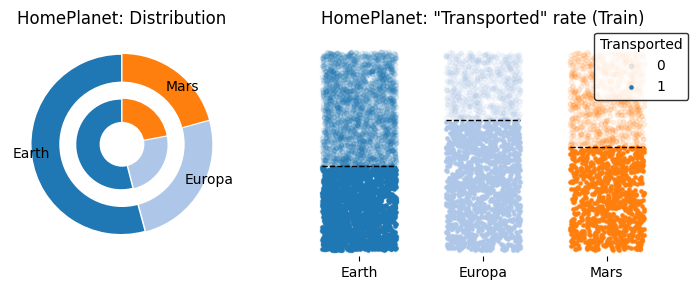

Explained HomePlanet values and transported rates in training dataset:


HomePlanet,#Passengers,Transported_Rate[%]
Earth,4602,42.394611
Europa,2131,65.884561
Mars,1759,52.302445


---------- CryoSleep | Outer:train, Inner:test ----------


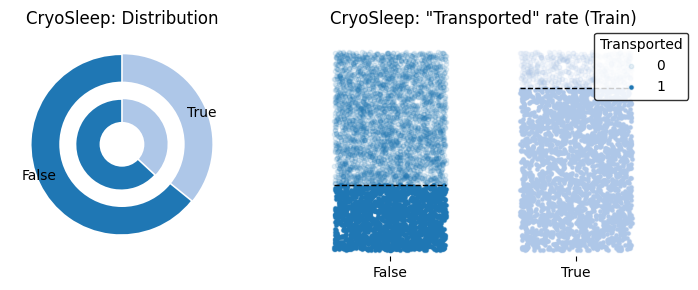

Explained CryoSleep values and transported rates in training dataset:


CryoSleep,#Passengers,Transported_Rate[%]
False,5439,32.892076
True,3037,81.758314


---------- Destination | Outer:train, Inner:test ----------


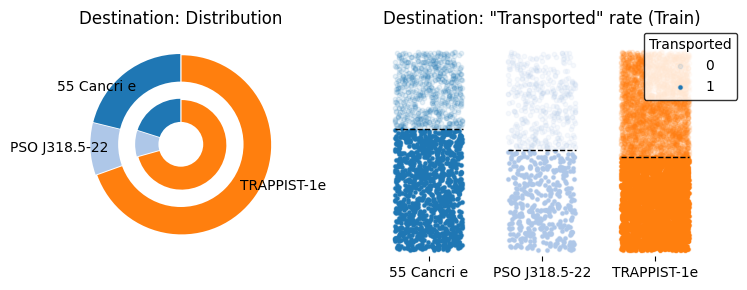

Explained Destination values and transported rates in training dataset:


Destination,#Passengers,Transported_Rate[%]
55 Cancri e,1800,61.000000
PSO J318.5-22,796,50.376884
TRAPPIST-1e,5915,47.117498


------------------------- Age -------------------------


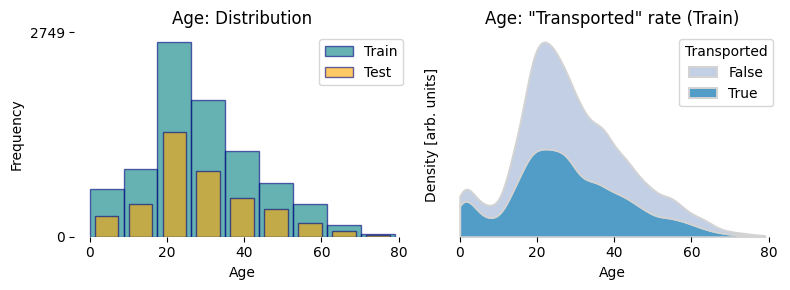

(Not suitable for a table)
---------- VIP | Outer:train, Inner:test ----------


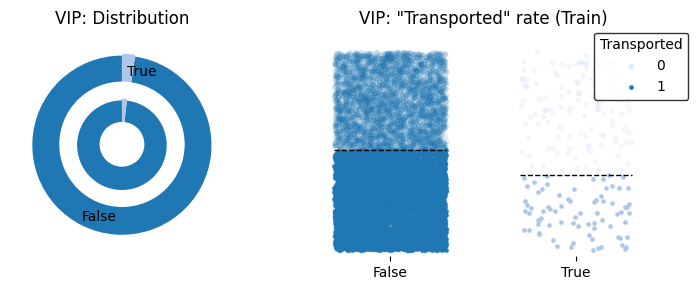

Explained VIP values and transported rates in training dataset:


VIP,#Passengers,Transported_Rate[%]
False,8291,50.633217
True,199,38.190955


------------------------- RoomService -------------------------


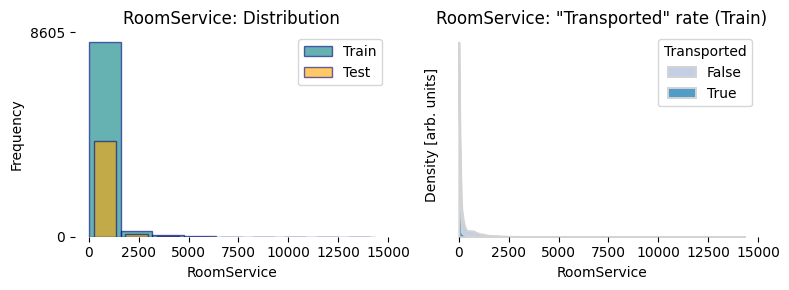

(Not suitable for a table)
------------------------- FoodCourt -------------------------


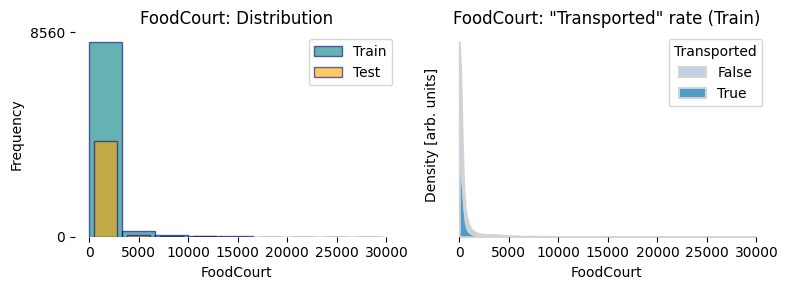

(Not suitable for a table)
------------------------- ShoppingMall -------------------------


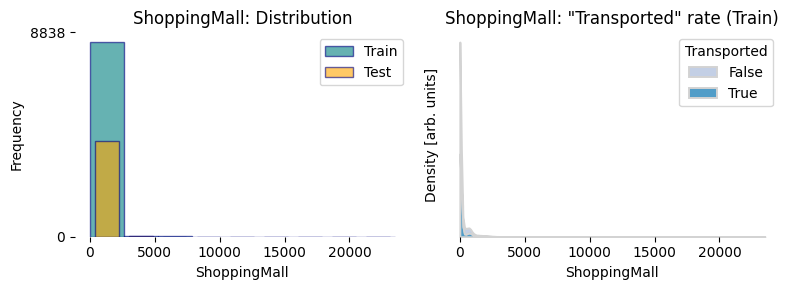

(Not suitable for a table)
------------------------- Spa -------------------------


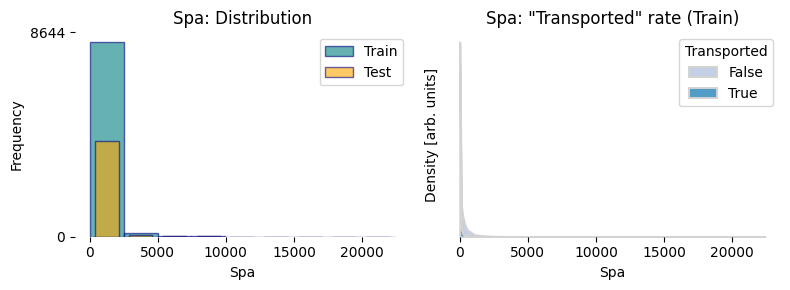

(Not suitable for a table)
------------------------- VRDeck -------------------------


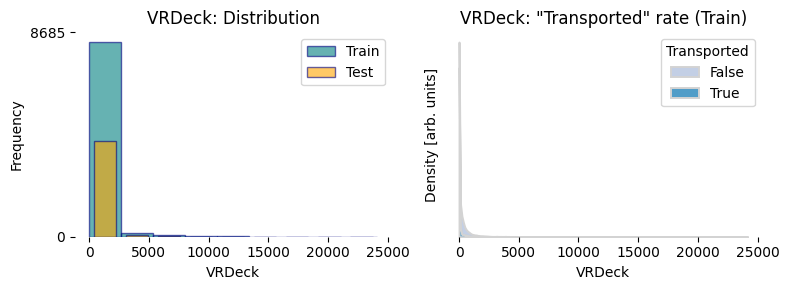

(Not suitable for a table)


In [3]:
# Select features to analyze:
features = [feat for feat in test_df.columns if 
            test_df[feat].dtype != 'object' or # Numeric or...
            test_df[feat].nunique()<10] # ...Few unique values

# Plot distribution of values and Transported rates for each feature:
for feature in features:
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
    if train_df[feature].dtype == 'object': # Non-numerical features:
        print('-'*10,f'{feature} | Outer:train, Inner:test','-'*10)
        plot_dist_pie(train_df,test_df,feature,ax1)
        plot_swarm(train_df,feature,ax2)    
    else: # Numerical features:
        print('-'*25,feature,'-'*25)
        plot_dist_hist(train_df,test_df,feature,ax1)
        plot_KDE(train_df,feature,ax2)
    fig.tight_layout()
    plt.show()
    # Display explanatory table only if there are equal or less than 10 unique values:
    if len(set(train_df[feature]))<=10:
        explain_stats(train_df,feature)
    else:
        print('(Not suitable for a table)')

Summary about the distribution of values and transported rates:

| Feature | <font color=blue> Distribution </font> | <font color=green> Transported rates </font> |
| :---: | :--- | :--- |
| <span style="font-weight:bold;">HomePlanet</span> | <font color=blue> Half of the passengers come from Earth, 1/4 from Europa and 1/4 from Mars  </font> | <font color=green> Europa has a slightly good rate (65%), Mars average (50%) and Earth slightly poor (40%) </font> |
| <span style="font-weight:bold;">CryoSleep</span> | <font color=blue> Only 1/3 of passengers were in CryoSleep  </font> | <font color=green> Excellent chances (80%) if Cryosleep, poor (30%) if not </font> |
| <span style="font-weight:bold;">Destination</span> | <font color=blue> 2/3 of passengers were going to Trappist, 1/4 to Cancri and 10% to PSO </font> | <font color=green> Those going to Cancri have good chances (60%), the rest average (50%) </font> |
| <span style="font-weight:bold;">Age</span> | <font color=blue> From 0 to 80, peak around 20-30 </font> | <font color=green> Good chances for the very young (less than 10 years old?), maybe average for the rest </font> |
| <span style="font-weight:bold;">VIP</span> | <font color=blue> Only 200 passengers are VIP </font> | <font color=green> VIP passengers have slightly bad chances (40%) </font> |
| <span style="font-weight:bold;">RoomService, FoodCourt, ShoppingMall, Spa, VRDeck</span> | <font color=blue> Only a few passengers spend more than a little money in services </font> | <font color=green> Can't tell from the plots </font> |

<a id="Data_analysis_correlations"></a>
## <span style="color:teal;font-weight:bold;">Correlations I (original data)</span>

Next, I study the <span style="font-weight:bold;">correlations in the original data, using the training dataset, only for those features analyzed in the previous section</span>. I build a correlation matrix with a 0.1 threshold correlation value, then only high correlations are painted.

Note: the correlation matrix needs numerical or boolean features. For this purpose, I One-Hot encode the non-numerical features, and group family-encoded-features in dotted traingles within the correlation matrix (correlations there are irrelevant).

In [4]:
import matplotlib.patches as patches

def encode_and_correlation(df,max_cats=10,target_col='Transported',
                           c_thres=0.1,plot_corr=True):
    """
    Encodes non-numeric features in a dataset and plots the correlation matrix.
    --- Inputs ---
    {df} [dataframe]: Dataframe to be encoded.
    {max_cats} [int]: Maximum number of categories for a non-numeric
    feature to be encoded. If the feature has more categories, it is ignored.
    {ref_col} [string]: Target column, it won't be encoded.
    {c_thres} [float]: Threshold correlation value, only exceeding values
    will be painted in the correlation matrix.
    {plot_corr} [boolean]: If True, plots the correlation matrix. If False, 
    doesn't plot it, but still returns the encoded dataframe.
    --- Outputs ---
    {df_enc} [dataframe]: Encoded dataframe.
    """
    # ===== ENCODING ===== 
    # One-Hot encode non-numerical features with few unique values:
    feat_enc = [feat for feat in df.columns if 
                df[feat].dtype == 'object' and # Numeric or...
                df[feat].nunique()<=max_cats] # ...Few unique values

    # Encode features:
    if len(feat_enc)>1:
        data_enc = pd.get_dummies(df[feat_enc])
        # Prepare dataframes having only numeric/boolean features:
        df_enc = pd.concat([df, data_enc], axis=1)
    else:
        df_enc = df.copy()
    # Sort columns alphabetically, but leave 'Transported' at the beggining in training dataset:
    df_enc = df_enc.reindex(sorted(df_enc.columns), axis=1)
    if target_col in df_enc:
        df_enc = df_enc[['Transported'] + [col for col in df_enc.columns
                                                       if col != target_col ]]
    else:
        df_enc = df_enc[[col for col in df_enc.columns]]
    # Drop source-encoded features: 
    df_enc = df_enc.drop(feat_enc,axis=1)
    # Drop not suitable features:
    feat_not_enc = [feat for feat in df.columns if
                    df[feat].dtype == 'object' and # Numeric or...
                    df[feat].nunique()>10] # ...Few unique values
    df_enc = df_enc.drop(feat_not_enc,axis=1)
    
    # ===== CORRELATION MATRIX ===== 
    if plot_corr:
        # Prepare data:
        corr = df_enc.corr() # Obtain correlations
        trimask = np.triu(np.ones_like(corr, dtype=bool)) # Mask upper triangle in correlations    
        # Plot correlations in training dataset:
        fig, ax = plt.subplots(figsize=(20, 10))
        sns.heatmap(corr, ax=ax, square=True,cmap='coolwarm',
                    vmin=-1, vmax=1, linecolor='w',lw=0.5, 
                    mask=trimask | (np.abs(corr) <= c_thres))
        # Separate the target correlations:
        ax.plot([1,1],[1,len(df_enc.columns)],color='k',lw=2)
        # Draw the correlations' triangle:
        ax.plot([1,len(df_enc.columns)],[1,len(df_enc.columns)],color='k',lw=0.5)
        ax.plot([1,len(df_enc.columns)],[len(df_enc.columns),len(df_enc.columns)],
                color='k',lw=1.5)
        # Identify blocks of similar features:
        main_name = [feat.split('_')[0] for feat in list(df_enc.columns)]
        index_counts = [(main_name.index(name),main_name.count(name))
                        for name in sorted(set(main_name))]
        for index, counts in index_counts:
            if counts>1: 
                triangle = [[index, index],
                            [index+counts, index+counts],
                            [index, index+counts]]
                ax.add_patch(patches.Polygon(triangle, edgecolor="k",facecolor='none',ls="--",lw=2))
        ax.set_title(f"Dataset Correlations", size=15)
        fig.tight_layout()
        plt.show()    
    
    return df_enc

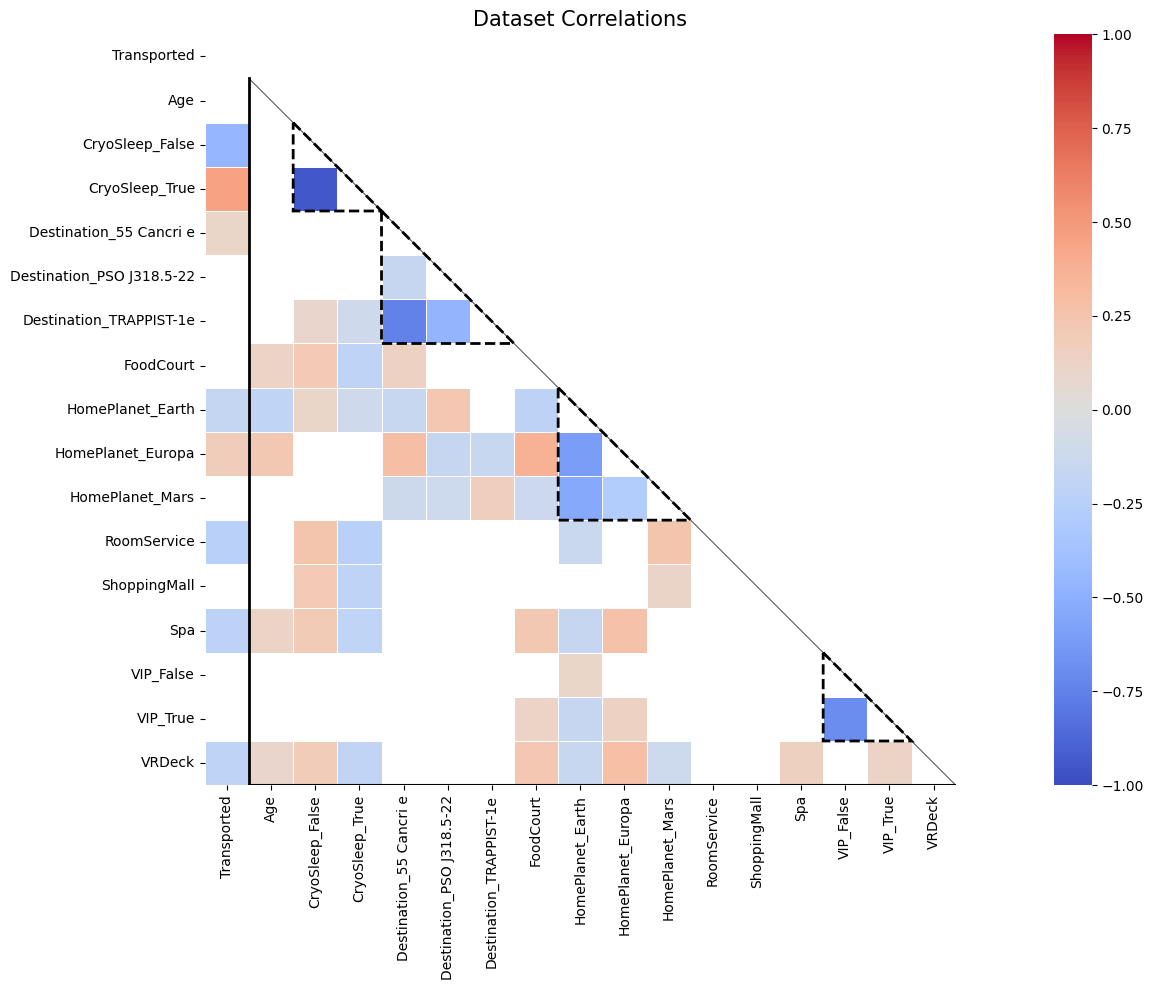

In [5]:
train_df_enc = encode_and_correlation(train_df)

I'm going to do a more detailed analysis later, but from this plot I highlight the following facts:

<span style="font-weight:bold;">Chances of transportation (first column):</span> 
- <span style="font-weight:bold;">CryoSleep</span>: Cryo-sleeping (True) is better.
- <span style="font-weight:bold;">Destination</span>: going to Cancri is better.
- <span style="font-weight:bold;">HomePlanet</span>: being from Earth is worse, from Europa is better. 
- <span style="font-weight:bold;">RoomService</span>: paying more is worse.
- <span style="font-weight:bold;">Spa</span>: paying more is worse.
- <span style="font-weight:bold;">VRDeck</span>: paying more is worse.

<span style="font-style:italic;">Note: the correlation matrix is strongly affected by the number of values with significant correlations, that's why the <span style="font-weight:bold;">VIP</span> feature is not painted, even though being VIP is an important indicator for Transportation. </span>

<span style="font-weight:bold;">Other observations:</span>

- Cryo-sleeping passengers spend less in services 
(<span style="font-weight:bold;">FoodCourt</span>
<span style="font-weight:bold;">RoomService</span>, 
<span style="font-weight:bold;">ShoppingMall</span>,
<span style="font-weight:bold;">Spa</span>,
<span style="font-weight:bold;">VRDeck</span>).
- The older the passenger, the more more likely is that they are from Europa. On the contrary, younger passengers are more likely to come from Earth.
- The following origin-destinations are more frequent: Europa-Cancri, Earth-PSO, Mars-Trappist.
- Passengers from Mars are more likely to spend more in RoomService and ShoppingMall.
- Passengers from Europa are more likely to spend more in Spa and VRDeck.

<a id="Feature_engineering"></a>
# <span style="color:teal;font-weight:bold;">Feature engineering</span>

In this section, I first engineer single original features, extracting encoded information from then, and later I generate new variables based on combination of two or more features.

By the end of the data engineering process, each feature in the dataset should be numeric, boolean, or non-numeric with a few unique values (so they can be easily encoded).

<a id="Feature_engineering_single"></a>
## <span style="color:teal;font-weight:bold;">Original single features</span>

The original features can contain encoded information that may be stored in new variables, or too complex information that could be simplified, or completely irrelevant information that could be deleted.

I analyze the original features in the order given in the dataset:

In [6]:
print('Order in original features:\n',[f for f in test_df.columns])

Order in original features:
 ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


Copy the original datasets as "SE", which will contain all original features and those engineered from single features:

In [7]:
# First generate the corrected datasets:
train_df_SE = train_df.copy()
test_df_SE = test_df.copy()

<a id="DA_FE_GroupMembers"></a>
### <span style="color:teal;font-weight:bold;">"PassengerId": new feature "GroupMembers"</span>

I begin by studying the <span style="font-weight:bold;">PassengerId</span> feature. According to the official definition:

<span style="font-weight:bold;">PassengerId</span> - A unique Id for each passenger. <span style="font-weight:bold;">.Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group</span>. People in a group are often family members, but not always.

I split <span style="font-weight:bold;">PassengerId</span> into the new features <span style="font-weight:bold;">IDgroup</span> (gggg) and <span style="font-weight:bold;">IDnumber</span> (pp) and study their unique values:

In [8]:
# Training dataset:
train_df_SE['IDgroup'] = train_df['PassengerId'].apply(
    lambda x: int(x.split('_')[0]))
train_df_SE['IDnumber'] = train_df['PassengerId'].apply(
    lambda x: int(x.split('_')[1]))
# Testing dataset:
test_df_SE['IDgroup'] = test_df['PassengerId'].apply(
    lambda x: int(x.split('_')[0]))
test_df_SE['IDnumber'] = test_df['PassengerId'].apply(
    lambda x: int(x.split('_')[1]))

In [9]:
print('Number of unique values in IDgroup (training dataset):', len(set(train_df_SE['IDgroup'])))
print('Number of unique values in IDnumber (training dataset):', len(set(train_df_SE['IDnumber'])))

Number of unique values in IDgroup (training dataset): 6217
Number of unique values in IDnumber (training dataset): 8


There are too many groups, <span style="font-weight:bold;">IDgroup</span> won't be useful for a Machine Learning model... However, identifying member's quantity in each group may help... The <span style="font-weight:bold;">IDnumber</span> gives an idea of the minimum number of people within a group, but the whole picture is missing.

I build the new feature <span style="font-weight:bold;">GroupMembers</span>, which identifies for each passenger the number of people sharing their <span style="font-weight:bold;">IDgroup</span>. In order to do that, I consider both training and testing datasets, with the following protocol:

* Identify the ocurrences for each unique value in <span style="font-weight:bold;">IDgroup</span>, in the total training+testing dataset.
  
* Assign the <span style="font-weight:bold;">GroupMembers</span> in each training and testing dataset.

* Drop features <span style="font-weight:bold;">IDgroup</span> and <span style="font-weight:bold;">IDnumber</span>.

In [10]:
# Identify ocurrences for every unique value in IDgroup:
ocurrences = pd.concat([train_df_SE['IDgroup'], test_df_SE['IDgroup']]).value_counts().to_dict()
for dataset in [train_df_SE,test_df_SE]:
    dataset['GroupMembers'] = dataset['IDgroup'].apply(lambda x: ocurrences[x])
# Drop unnecessary features:
for feature in ['PassengerId','IDgroup','IDnumber']:
    if feature in train_df_SE: # Just in case feature is already dropped
        train_df_SE = train_df_SE.drop(feature,axis=1)
        test_df_SE = test_df_SE.drop(feature,axis=1)

Let's see the distribution of values and Transported rates for <span style="font-weight:bold;">GroupMembers</span>:

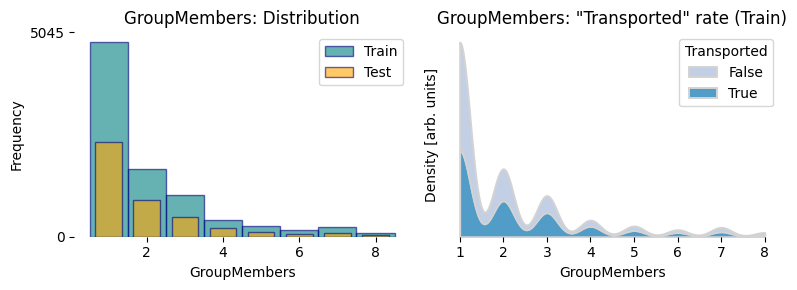

Explained GroupMembers values and transported rates in training dataset:


GroupMembers,#Passengers,Transported_Rate[%]
1,4805,45.244537
2,1682,53.804994
3,1020,59.313725
4,412,64.077670
5,265,59.245283
6,174,61.494253
7,231,54.112554
8,104,39.423077


In [11]:
# Plot distribution of values and Transported rates:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
plot_dist_hist(train_df_SE,test_df_SE,'GroupMembers',ax1,bin_step=1)
plot_KDE(train_df_SE,'GroupMembers',ax2)
fig.tight_layout()
plt.show()
# Display explanatory table:
explain_stats(train_df_SE,'GroupMembers')

<a id="DA_FE_CryoSleep"></a>
### <span style="color:teal;font-weight:bold;">"CryoSleep": make boolean/numeric</span>

<span style="font-weight:bold;">CryoSleep</span> feature is very simple, with only True or False values. To make life easier for Machine Learning models, I will convert True to 1 and False to 0.

In [12]:
for dataset in [train_df_SE,test_df_SE]:
    dataset['CryoSleep'] = dataset['CryoSleep'].apply(
        lambda x: np.nan if x!=x else (1 if x else 0))

<a id="DA_FE_Cabin"></a>
### <span style="color:teal;font-weight:bold;">"Cabin": new features "Cabin_1st" and "Cabin_isP"</span>

The <span style="font-weight:bold;">Cabin</span> feature has too many unique values and couldn't be analyzed properly. Let's look a few examples:

In [13]:
cabin = list(train_df['Cabin'].loc[~train_df['Cabin'].isna()].values)+\
        list(test_df['Cabin'].loc[~test_df['Cabin'].isna()].values)
print(list(set(cabin))[:20])

['C/180/P', 'F/1716/P', 'G/727/P', 'F/479/P', 'F/661/S', 'G/386/S', 'G/80/S', 'E/406/S', 'F/1218/P', 'G/548/S', 'F/1438/S', 'F/1344/P', 'G/1319/S', 'F/1169/S', 'G/1410/P', 'G/1177/S', 'E/148/S', 'F/1012/S', 'B/218/S', 'E/251/S']


All values follow the same patter: 'Letter/Number/Letter'. I will generate 3 new features accounting for them: <span style="font-weight:bold;">Cabin_1st</span>, <span style="font-weight:bold;">Cabin_2nd</span> and <span style="font-weight:bold;">Cabin_3rd</span>, respectively. Then, I will drop the original <span style="font-weight:bold;">Cabin</span> feature.

In [14]:
cabin_X = ['Cabin_1st','Cabin_2nd','Cabin_3rd']
for i,cabin in enumerate(cabin_X):
    if cabin not in train_df_SE: # In case faeture it's already created
        # Training dataset:
        train_df_SE[cabin] = train_df['Cabin'].apply(
            lambda x: np.nan if x!=x else (
                x.split('/')[i]))
        # Testing dataset:
        test_df_SE[cabin] = test_df['Cabin'].apply(
            lambda x: np.nan if x!=x else (
                x.split('/')[i]))
# Summarize:
for c in cabin_X:
    print(f'Unique values in {c} (training/testing):',
          len({x for x in train_df_SE[c] if x==x}),'/',
          len({x for x in test_df_SE[c] if x==x}))

Unique values in Cabin_1st (training/testing): 8 / 8
Unique values in Cabin_2nd (training/testing): 1817 / 1505
Unique values in Cabin_3rd (training/testing): 2 / 2


Only <span style="font-weight:bold;">Cabin_1st</span> and <span style="font-weight:bold;">Cabin_3rd</span> are suitable for ML models, while <span style="font-weight:bold;">Cabin_2nd</span> has too many unique values.

I drop <span style="font-weight:bold;">Cabin_2nd</span> and <span style="font-weight:bold;">Cabin</span>, and then plot the distribution of values and Transported rates for the new features.

---------- Cabin_1st | Outer:train, Inner:test ----------


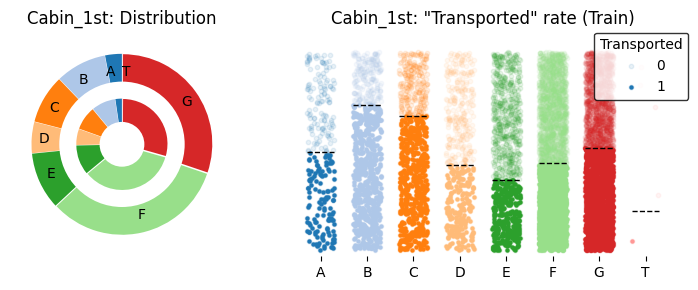

Explained Cabin_1st values and transported rates in training dataset:


Cabin_1st,#Passengers,Transported_Rate[%]
A,256,49.609375
B,779,73.427471
C,747,68.005355
D,478,43.305439
E,876,35.730594
F,2794,43.987115
G,2559,51.621727
T,5,20.000000


---------- Cabin_3rd | Outer:train, Inner:test ----------


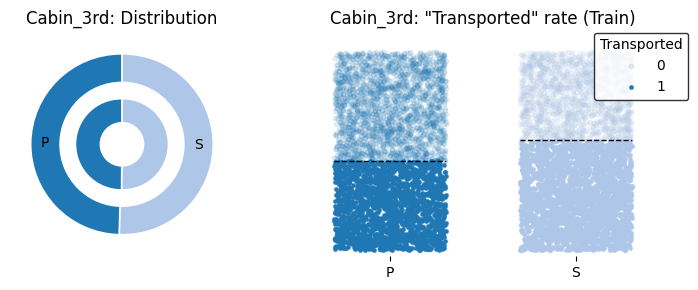

Explained Cabin_3rd values and transported rates in training dataset:


Cabin_3rd,#Passengers,Transported_Rate[%]
P,4206,45.126010
S,4288,55.503731


In [15]:
# Drop unnecessary features:
for feature in ['Cabin','Cabin_2nd']:
    if feature in train_df_SE: # Just in case feature is already dropped
        train_df_SE = train_df_SE.drop(feature,axis=1)
        test_df_SE = test_df_SE.drop(feature,axis=1)
# Plot distribution of values and Transported rates:
for feature in ['Cabin_1st','Cabin_3rd']:
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
    print('-'*10,f'{feature} | Outer:train, Inner:test','-'*10)
    plot_dist_pie(train_df_SE,test_df_SE,feature,ax1)
    plot_swarm(train_df_SE,feature,ax2)    
    fig.tight_layout()
    plt.show()
    # Display explanatory table:
    explain_stats(train_df_SE,feature)

Excellent news! The old feature <span style="font-weight:bold;">Cabin</span> encoded much information that was recovered in the new <span style="font-weight:bold;">Cabin_1st</span> and <span style="font-weight:bold;">Cabin_3rd</span> features.

Lastly, because <span style="font-weight:bold;">Cabin_3rd</span> is a binary feature (either 'S' or 'P'), I will redefine it as <span style="font-weight:bold;">Cabin_isP</span>, with values equal to 1 (='P') or 0 (='S').

In [16]:
# Generate 'Cabin_isP':
if 'Cabin_isP' not in train_df_SE: # In case faeture it's already created
    # Training dataset:
    train_df_SE['Cabin_isP'] = train_df_SE['Cabin_3rd'].apply(
        lambda x: np.nan if x!=x else (1 if x=='P' else 0))
    # Testing dataset:
    test_df_SE['Cabin_isP'] = test_df_SE['Cabin_3rd'].apply(
        lambda x: np.nan if x!=x else (1 if x=='P' else 0))
# Drop 'Cabin_3rd':
if 'Cabin_3rd' in train_df_SE: # Just in case feature is already dropped
    train_df_SE = train_df_SE.drop('Cabin_3rd',axis=1)
    test_df_SE = test_df_SE.drop('Cabin_3rd',axis=1)

<a id="DA_FE_Destination"></a>
### <span style="color:teal;font-weight:bold;">"Destination" redefinition</span>

The current <span style="font-weight:bold;">Destination</span> feature's unique values are hard to read: '55 Cancri e', 'PSO J318.5-22' and 'TRAPPIST-1e'. I redefine them as 'Cancri', 'PSO' and "Trappist', respectively.

In [17]:
train_df_SE["Destination"] = train_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)
test_df_SE["Destination"] = test_df["Destination"].apply(
    lambda x: np.nan if x!=x else (
    "Cancri" if x=="55 Cancri e" else (
        "PSO" if x=="PSO J318.5-22" else "Trappist"))
)

<a id="DA_FE_VIP"></a>
### <span style="color:teal;font-weight:bold;">"VIP": make boolean/numeric</span>

I will apply to <span style="font-weight:bold;">VIP</span> the same procedure as <span style="font-weight:bold;">CryoSleep</span>: convert True to 1 and False to 0.

In [18]:
for dataset in [train_df_SE,test_df_SE]:
    dataset['VIP'] = dataset['VIP'].apply(
        lambda x: np.nan if x!=x else (1 if x else 0))

<a id="DA_FE_Expenses_redefinition"></a>
### <span style="color:teal;font-weight:bold;">Expense features redefinition</span>

Features <span style="font-weight:bold;">RoomService</span>,
<span style="font-weight:bold;">FoodCourt</span>,
<span style="font-weight:bold;">ShoppingMall</span>,
<span style="font-weight:bold;">Spa</span> and
<span style="font-weight:bold;">VRDeck</span> describe expenses incurred by passengers. For future convenience, I will simplify their names as follows:

- <span style="font-weight:bold;">RoomService</span> --> <span style="font-weight:bold;">ExpRS</span>
- <span style="font-weight:bold;">FoodCourt</span> --> <span style="font-weight:bold;">ExpFC</span>
- <span style="font-weight:bold;">ShoppingMall</span> --> <span style="font-weight:bold;">ExpSM</span>
- <span style="font-weight:bold;">Spa</span> --> <span style="font-weight:bold;">ExpSpa</span>
- <span style="font-weight:bold;">VRDeck</span> --> <span style="font-weight:bold;">ExpVR</span>

In [19]:
for dataset in [train_df_SE, test_df_SE]:
    dataset.rename(columns={
        'RoomService': 'ExpRS',
        'FoodCourt': 'ExpFC',
        'ShoppingMall': 'ExpSM',
        'Spa': 'ExpSpa',
        'VRDeck': 'ExpVR'
        }, inplace=True)

<a id="DA_FE_Expense_Range"></a>
### <span style="color:teal;font-weight:bold;">Expense features: new features "X_Range"</span>

The expense features (defined in the previous section) are all numerical that span a wide range (from 0 to thousands) with a very skewed distribution: the vast majority of passengers spend very little, while the rest of the expense distribution is occupied by relatively few passengers. 

Consequently, I <span style="font-weight:bold;">simplify the information by using a logarithmic distribution</span>.

<span style="font-style:italic;">Note: the logarithm operation requires values strictly greater than 0. For this purpose, I consider all 0 values as a tenth fraction the minimum non-zero value. </span>

In [20]:
def make_range_feature(df_train,df_test,feat,zero_value=None):
    """
    Makes a new range-feature based on a numerical feature and a
    log10 distribution. The original feature must have non-negative values.
    --- Inputs ---
    {df_train} [Dataframe]: Training Dataframe to be updated.
    {df_test} [Dataframe]: Testing Dataframe to be updated.
    {feat} [String]: Feature that will be used for the new feature.
    {zero_value} [Float or None]: Value to be assigned to the 0 values in
    the original feature (not including NaN). If None, it is determined
    automatically as the minimum non-zero value in both datasets.
    --- Outputs ---
    {df_train_upd,df_test_upd} [Dataframe]: Updated Training/Testing 
    Dataframes.
    """
    new_feat = f'{feat}_Range' # New engineered feature
    # Find minimum fare above 0 and maximum fare:
    all_exp = set(pd.concat([df_train[feat], df_test[feat]])) # All expenses
    # Get Minimum non-zero and Maximum expenses:
    min_exp = sorted(all_exp)[1] if zero_value is None else zero_value 
    max_exp = max(all_exp) # Manimum expense
    # Create the new expense_Range feature:
    df_train_upd, df_test_upd = df_train.copy(), df_test.copy()
    for dataset in [df_train_upd,df_test_upd]:
        # First copy the expense feature and fix all zero values:
        dataset[new_feat] = dataset[feat]
        dataset.loc[dataset[new_feat]==0,new_feat] = min_exp
        # Convert to logarithmic scale:
        dataset[new_feat] = np.log10(dataset[new_feat])
        # Encode to bins with width equal to 1:
        dataset[new_feat] = dataset[new_feat].apply(
            lambda x: np.nan if x!=x else np.ceil(x))
    return df_train_upd, df_test_upd

def explain_range_values(df,feat_base):
    """
    Explains the scale of a ranged-feature based on the original feature,
    and the Transported rates per range category.
    --- Inputs ---
    {df} [Dataframe]: Dataframe with {feat_base} and ranged-feature columns,
    which must have the name "{feat_base}_Ranged".
    {feat_base} [String]: Original feature.
    """
    # Identify ranged-feature and initiate explanatory dataframe:
    feat_range = feat_base+'_Range'
    feat_expl = pd.DataFrame(columns=[feat_range,feat_base,
                                      '#Passengers','Transported_Rate[%]'])
    # Identify minimum and maximum values for array:
    min_val = int(np.floor(np.min(df[feat_range])))\
    if np.min(df[feat_range])<0 else int(np.min(df[feat_range]))
    max_val = int(np.max(df[feat_range]))+1
    feat_expl[feat_range] = np.arange(min_val,max_val,1) # Generate array
    # Boundaries for each range-category:
    feat_expl[feat_base] = [f'[{10**(i-1)}, {10**i})' for
                            i in feat_expl[feat_range]]
    # Number of passengers in the range-category:
    feat_expl['#Passengers'] = [len(df[df[feat_range] == x])
                                for x in feat_expl[feat_range]]
    # Transported rates for each Expense_Range category:
    feat_expl['Transported_Rate[%]'] = [
        len(df[(df[feat_range] == x) & # Select expense range
            (df['Transported'] == 1)])/ # Passengers who were transported
        (len(df[(df[feat_range] == x)])+0.01) # Total passengers
        for x in feat_expl[feat_range] # Iterate through all expense range values
    ]
    feat_expl['Transported_Rate[%]'] *= 100 # Convert from fraction to [%]
    # Display:
    print(f'Explained {feat_range} values and Transported rates in training dataset:')
    display(feat_expl.style.hide())

In [21]:
exp_feats = ['ExpRS','ExpFC', 'ExpSM', 'ExpSpa', 'ExpVR']
for feat in exp_feats:
    train_df_SE, test_df_SE = make_range_feature(
        train_df_SE,test_df_SE,feat)

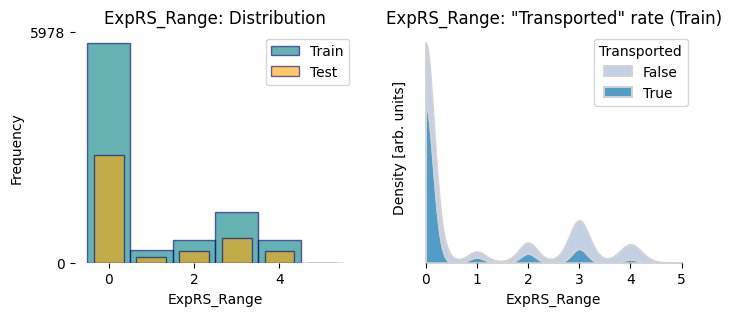

Explained ExpRS_Range values and Transported rates in training dataset:


ExpRS_Range,ExpRS,#Passengers,Transported_Rate[%]
0,"[0.1, 1)",5694,62.732591
1,"[1, 10)",322,37.576473
2,"[10, 100)",583,35.848442
3,"[100, 1000)",1313,23.990678
4,"[1000, 10000)",599,13.021485
5,"[10000, 100000)",1,0.000000


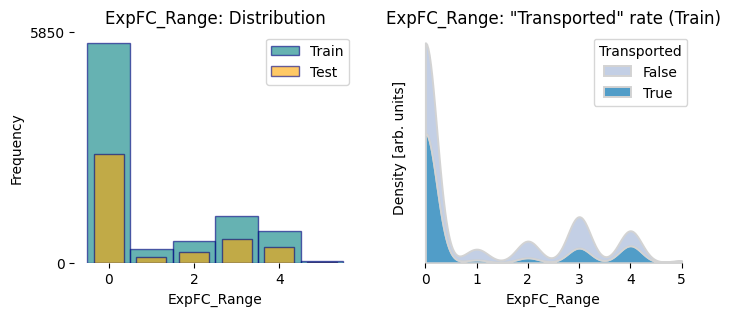

Explained ExpFC_Range values and Transported rates in training dataset:


ExpFC_Range,ExpFC,#Passengers,Transported_Rate[%]
0,"[0.1, 1)",5572,58.327246
1,"[1, 10)",347,20.460505
2,"[10, 100)",554,22.382267
3,"[100, 1000)",1174,31.430737
4,"[1000, 10000)",811,52.527096
5,"[10000, 100000)",52,74.985580


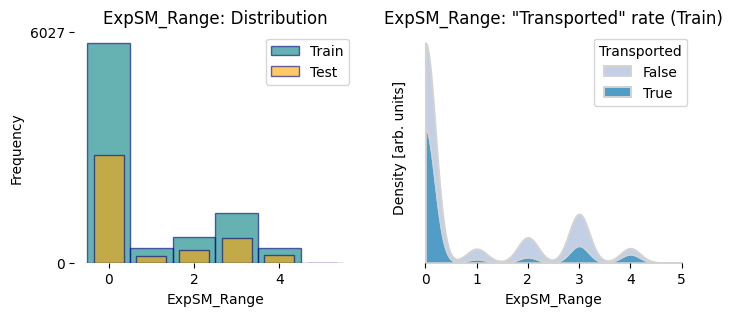

Explained ExpSM_Range values and Transported rates in training dataset:


ExpSM_Range,ExpSM,#Passengers,Transported_Rate[%]
0,"[0.1, 1)",5740,58.919758
1,"[1, 10)",375,24.799339
2,"[10, 100)",684,20.906127
3,"[100, 1000)",1305,32.796684
4,"[1000, 10000)",377,57.292910
5,"[10000, 100000)",4,49.875312


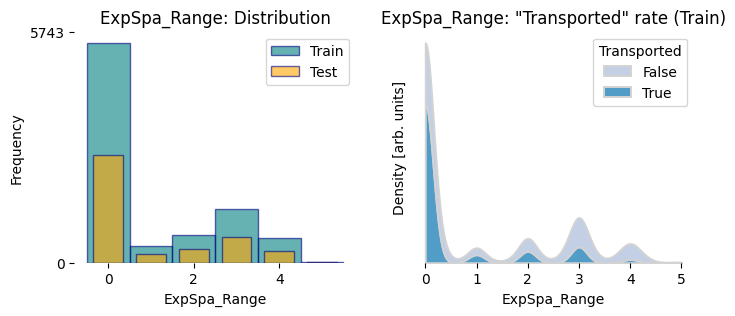

Explained ExpSpa_Range values and Transported rates in training dataset:


ExpSpa_Range,ExpSpa,#Passengers,Transported_Rate[%]
0,"[0.1, 1)",5470,63.162590
1,"[1, 10)",405,42.714995
2,"[10, 100)",681,36.269658
3,"[100, 1000)",1325,25.811126
4,"[1000, 10000)",605,11.570057
5,"[10000, 100000)",24,0.000000


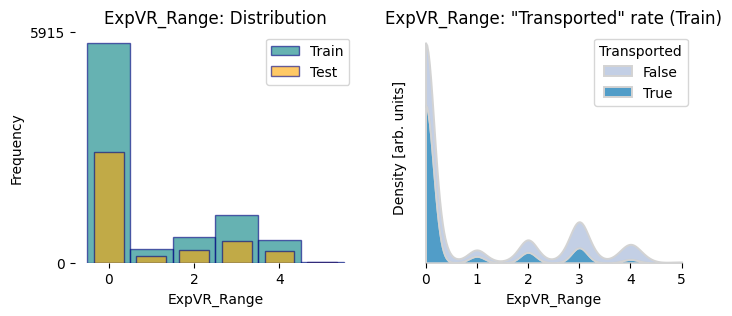

Explained ExpVR_Range values and Transported rates in training dataset:


ExpVR_Range,ExpVR,#Passengers,Transported_Rate[%]
0,"[0.1, 1)",5634,62.087217
1,"[1, 10)",362,39.501671
2,"[10, 100)",660,35.150983
3,"[100, 1000)",1228,27.035610
4,"[1000, 10000)",593,12.647342
5,"[10000, 100000)",28,0.000000


In [22]:
# Plot distribution of values, survival rates and explain ranged-values:
for feat in exp_feats:
    feat_range = feat+'_Range' # Engineered feature
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) 
    plot_dist_hist(train_df_SE,test_df_SE,feat_range,ax1,bin_step=1)
    plot_KDE(train_df_SE,feat_range,ax2)    
    plt.show()
    explain_range_values(train_df_SE,feat) # Explained values:

Information is much simpler now and easier to visualize. There are some general highlights:

* For all new ranged-features, the most common category is 0, integrated mainly by passengers with zero expenses. Transported rates in all cases are close to 60%.

* Ignoring the category 0, expenses follow two opposite patterns:

  - For <span style="font-weight:bold;">ExpRS_Range</span>, <span style="font-weight:bold;">ExpSpa_Range</span> and <span style="font-weight:bold;">ExpVR_Range</span>: the <span style="color:green">higher the expense</span>, the <span style="color:red">worse Transported rate</span>.
  
  - For <span style="font-weight:bold;">ExpFC_Range</span> and <span style="font-weight:bold;">ExpSM_Range</span>: the <span style="color:green">higher the expense</span>, the <span style="color:green">better Transported rate</span>.

<a id="DA_FE_Name"></a>
### <span style="color:teal;font-weight:bold;">"Name" feature: new feature "Ocurrence_LastName"</span>

Is there any encoded information in the <span style="font-weight:bold;">Name</span> feature? Let's see a few examples:

In [23]:
train_df['Name'].head(10)

0       Maham Ofracculy
1          Juanna Vines
2         Altark Susent
3          Solam Susent
4     Willy Santantines
5     Sandie Hinetthews
6    Billex Jacostaffey
7    Candra Jacostaffey
8         Andona Beston
9        Erraiam Flatic
Name: Name, dtype: object

Names come in the format "FirstName LastName". People bearing the same last name are likely belonging to the same family. 

Then, I create a new feature <span style="font-weight:bold;">Ocurrence_LastName</span>, which records the ocurrence of the last name for each passenger.

In [24]:
# Create Name_Last feature (temporarily):
if 'Name_Last' not in train_df_SE: # In case faeture it's already created
    # Training dataset:
    train_df_SE['Name_Last'] = train_df['Name'].apply(
        lambda x: np.nan if x!=x else (
            x.split(' ')[-1]))
    # Testing dataset:
    test_df_SE['Name_Last'] = test_df['Name'].apply(
        lambda x: np.nan if x!=x else (
            x.split(' ')[-1]))
    
# Identify ocurrences for every unique value in Name_Last:
ocurrences = pd.concat([train_df_SE['Name_Last'], test_df_SE['Name_Last']]).value_counts().to_dict()
for dataset in [train_df_SE,test_df_SE]:
    dataset['Ocurrence_LastName'] = dataset['Name_Last'].apply(
        lambda x: np.nan if x!=x else ocurrences[x])

# Drop unnecessary features:
for feature in ['Name','Name_Last']:
    if feature in train_df_SE: # Just in case feature is already dropped
        train_df_SE = train_df_SE.drop(feature,axis=1)
        test_df_SE = test_df_SE.drop(feature,axis=1)

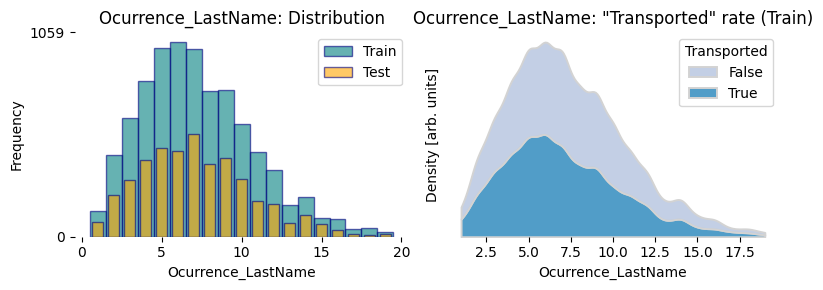

---------- Outer:train, Inner:test ----------


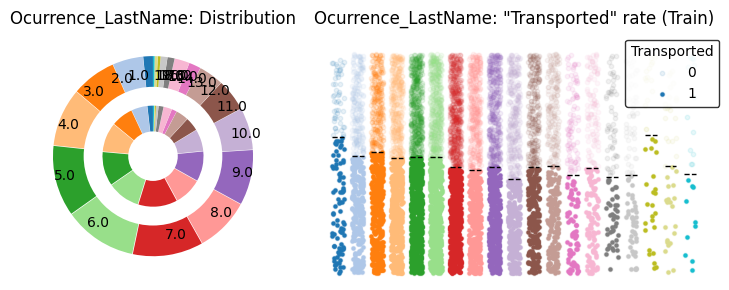

In [25]:
# Plot distribution of values and Transported rates:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
plot_dist_hist(train_df_SE,test_df_SE,'Ocurrence_LastName',ax1,bin_step=1)
plot_KDE(train_df_SE,'Ocurrence_LastName',ax2)     
fig.tight_layout()
plt.show()
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
print('-'*10,'Outer:train, Inner:test','-'*10)
plot_dist_pie(train_df_SE,test_df_SE,'Ocurrence_LastName',ax1)
plot_swarm(train_df_SE,'Ocurrence_LastName',ax2,xlabels_off=True)    
fig.tight_layout()
plt.show()

With a few exceptions, the general behavior indicates that the more ocurrences in the last name, the worse Transported rate.

<a id="Feature_engineering_single_corr"></a>
### <span style="color:teal;font-weight:bold;">Correlations II (original and single engineered features)</span>

So far, I've modified, dropped or generated new features from single original features. Let's have a look at the correlation at the current dataset:

In [26]:
print('\nFeatures: names and data types:\n')
print(train_df_SE.dtypes)


Features: names and data types:

HomePlanet             object
CryoSleep             float64
Destination            object
Age                   float64
VIP                   float64
ExpRS                 float64
ExpFC                 float64
ExpSM                 float64
ExpSpa                float64
ExpVR                 float64
Transported              bool
GroupMembers            int64
Cabin_1st              object
Cabin_isP             float64
ExpRS_Range           float64
ExpFC_Range           float64
ExpSM_Range           float64
ExpSpa_Range          float64
ExpVR_Range           float64
Ocurrence_LastName    float64
dtype: object


All features are numeric, except for <span style="font-weight:bold;">HomePlanet</span>, <span style="font-weight:bold;">Destination</span> and <span style="font-weight:bold;">Cabin_1st</span>, which have 3, 3 and 8 categories, respectively. I will encode them and then plot the correlation matrix.

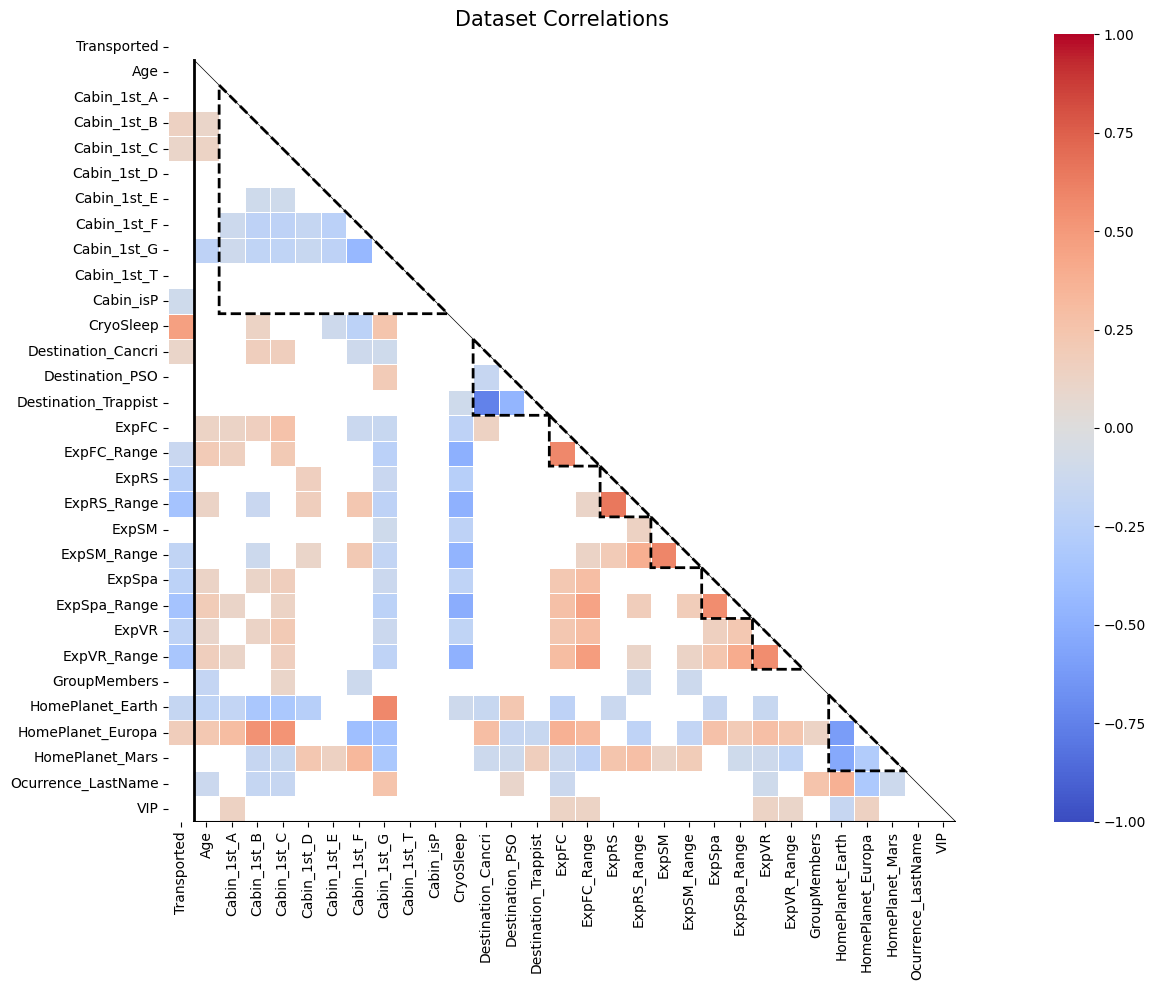

In [27]:
train_df_SE_enc = encode_and_correlation(train_df_SE)
test_df_SE_enc = encode_and_correlation(test_df_SE,plot_corr=False)

Compared to the first correlation matrix (original dataset), I can extract new conclusions:

- <span style="font-weight:bold;">Cabin_1st_A</span>, <span style="font-weight:bold;">Cabin_1st_B</span> and <span style="font-weight:bold;">Cabin_isP</span> are noticeably correlated with <span style="font-weight:bold;">Transported</span>.

- The <span style="font-weight:bold;">Cabin_1st_X</span> family of features is significantly correlated to the other features, specially <span style="font-weight:bold;">HomePlanet</span>.

- <span style="font-weight:bold;">Ocurrence_LastName</span> has moderate correlations, specially with <span style="font-weight:bold;">HomePlanet</span> and some <span style="font-weight:bold;">Cabin_1st_X</span>.

Next, I move on to engineering new features based on the combination of two or more features.

<a id="Feature_engineering_combined"></a>
## <span style="color:teal;font-weight:bold;">Combined features</span>

Copy the engineered datasets "SE" as "CE", which will contain all original features, those engineered from single features and those engineered from combined features:

In [28]:
train_df_CE, test_df_CE = train_df_SE.copy(), test_df_SE.copy()

<a id="DA_FE_FromTo"></a>
### <span style="color:teal;font-weight:bold;">"FromTo" new feature (from "HomePlanet" and "Destination")</span>

In the Titanic voyage, <span style="font-weight:bold;">the itinerary for any passenger can be defined by their HomePlanet feature and Destination</span>. Possibilities are limited: from [Earth, Europa, Mars] to [Cancri, PSO, Trappist].

<span style="font-weight:bold;">I will create a new feature called FromTo, containing strings with the format "{HomePlanet}-{Destination}".</span> 

<span style="font-style:italic;">Note: Any missing value in either <span style="font-weight:bold;">HomePlanet</span> or <span style="font-weight:bold;">Destination</span> will be translated in a missing value in <span style="font-weight:bold;">FromTo</span>.</span>

In [29]:
# Define feature:
for dataset in [train_df_CE, test_df_CE]:
    dataset["FromTo"] = dataset["HomePlanet"] + '-' + dataset["Destination"]

----------  FromTo | Outer:train, Inner:test ----------


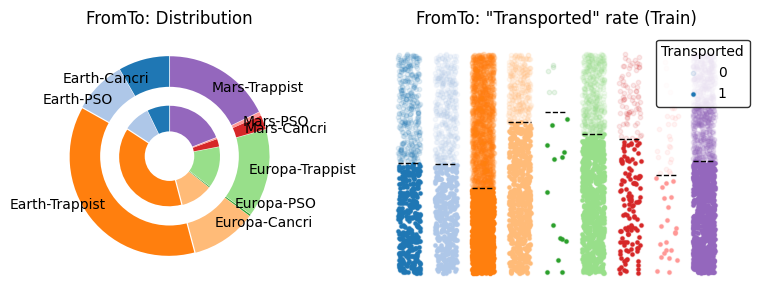

Explained FromTo values and transported rates in training dataset:


FromTo,#Passengers,Transported_Rate[%]
Earth-Cancri,690,50.434783
Earth-PSO,712,49.859551
Earth-Trappist,3101,38.922928
Europa-Cancri,886,68.961625
Europa-PSO,19,73.684211
Europa-Trappist,1189,63.498738
Mars-Cancri,193,61.139896
Mars-PSO,49,44.897959
Mars-Trappist,1475,51.186441


In [30]:
# Plot distribution of values and Transported rates:
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
print('-'*10,f' FromTo | Outer:train, Inner:test','-'*10)
plot_dist_pie(train_df_CE,test_df_CE,"FromTo",ax1)
plot_swarm(train_df_CE,"FromTo",ax2,xlabels_off=True)    
fig.tight_layout()
plt.show()
# Display explanatory table:
explain_stats(train_df_CE,"FromTo")

<a id="DA_FE_Expense_ratio"></a>
### <span style="color:teal;font-weight:bold;">Expense-related new family of features (from "ExpFC", "ExpSM", "ExpRS", "ExpSpa" and "ExpVR")</span>

The numerical features related to expenses are all numeric and span a very wide range, from a few units to tens of thousands. I already made ranged-expenses for all these features, but now I'll work with the original ones in order to explore the following options:

* Total sum of expenses, named <span style="font-weight:bold;">TotalExp</span>.
* Ratio between two expenses X and Y, named <span style="font-weight:bold;">X_over_Y</span>.

The first option (sum) will have a wide range of values, then I make a ranged-version as well: <span style="font-weight:bold;">TotalExp_Range</span>. 

The second option (ratios) will also display a wide range of values, close to 0 when the X feature is much smaller than the Y feature, or many orders of magnitude (100,1000,etc.) in the opposite case. Therefore, I make a ranged-version as well of these ratio-features: <span style="font-weight:bold;">X_over_Y_Range</span>.

Let's start with the <span style="font-weight:bold;">TotalExp</span> family:

In [31]:
# Create 'TotalExp' feature:
if 'TotalExp' not in test_df_CE:
    for dataset in [train_df_CE,test_df_CE]:
        dataset['TotalExp'] = dataset['ExpFC']+dataset['ExpSM']+\
        dataset['ExpRS']+dataset['ExpSpa']+dataset['ExpVR']
# Create 'TotalExp_Range' feature:
train_df_CE, test_df_CE = make_range_feature(
    train_df_CE,test_df_CE,'TotalExp',zero_value=1)

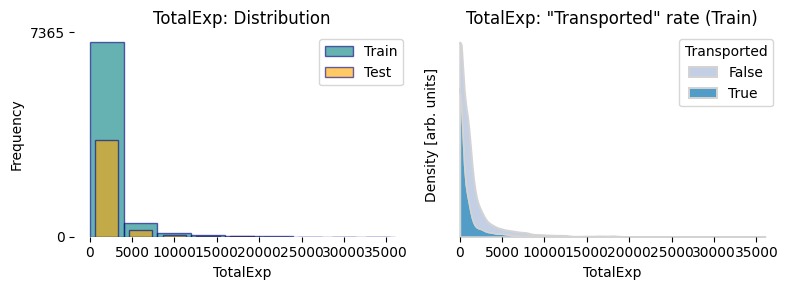

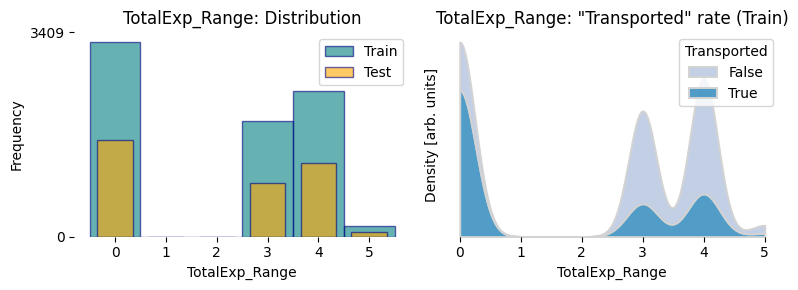

Explained TotalExp_Range values and Transported rates in training dataset:


TotalExp_Range,TotalExp,#Passengers,Transported_Rate[%]
0,"[0.1, 1)",3247,78.379802
1,"[1, 10)",0,0.000000
2,"[10, 100)",0,0.000000
3,"[100, 1000)",1929,29.600676
4,"[1000, 10000)",2436,30.459645
5,"[10000, 100000)",173,31.212069


In [32]:
# Plot distribution of values, survival rates and explain ranged-values:
for feat in ['TotalExp','TotalExp_Range']:
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
    bin_step = 1 if feat=='TotalExp_Range' else None
    plot_dist_hist(train_df_CE,test_df_CE,feat,ax1,bin_step=bin_step)
    plot_KDE(train_df_CE,feat,ax2)     
    fig.tight_layout()
    plt.show()
explain_range_values(train_df_CE,'TotalExp')

Good news, <span style="font-weight:bold;">TotalExp_Range</span> separates the data into two groups with similar Transported rates: either very low expenses (value 0, including zero expenses), with high Transported rate (78%) or at least 100 (values 3,4,5), with low transported rates (30%).

I will keep this ranged-feature and drop <span style="font-weight:bold;">TotalExp</span>.

In [33]:
if 'TotalExp' in train_df_CE: # Just in case feature is already dropped
    train_df_CE = train_df_CE.drop('TotalExp',axis=1)
    test_df_CE = test_df_CE.drop('TotalExp',axis=1)

Now let's create the ratio-expenses and their ranged versions:

In [34]:
# Create ratio-expenses:
expenses = ['ExpFC','ExpSM','ExpRS','ExpSpa','ExpVR']
for feat1 in expenses:
    for feat2 in {feat for feat in expenses if feat!=feat1}:
        feat_ratio = f'{feat1}_over_{feat2}' # Feature name (Ratio)
        if feat_ratio not in test_df_CE:
            for dataset in [train_df_CE,test_df_CE]:
                dataset[feat_ratio] = dataset[feat1]/(dataset[feat2]+0.01)
# Create ranged-ratio-expenses features:
ratio_feats = [col for col in test_df_CE.columns if 
               '_over_' in col and '_Range' not in col]
for feat in ratio_feats:
    train_df_CE, test_df_CE = make_range_feature(
        train_df_CE,test_df_CE,feat,zero_value=1)

As there are 5 original expenses categories, the number of ratio-features and ranged-ratio-features is 5x4=20 each, for all possible combinations. Most probably, information will be repetitive along these variation, then I want to select the most important features. Therefore, I study the correlation matrix, focusing on the Transported-correlation (first column):

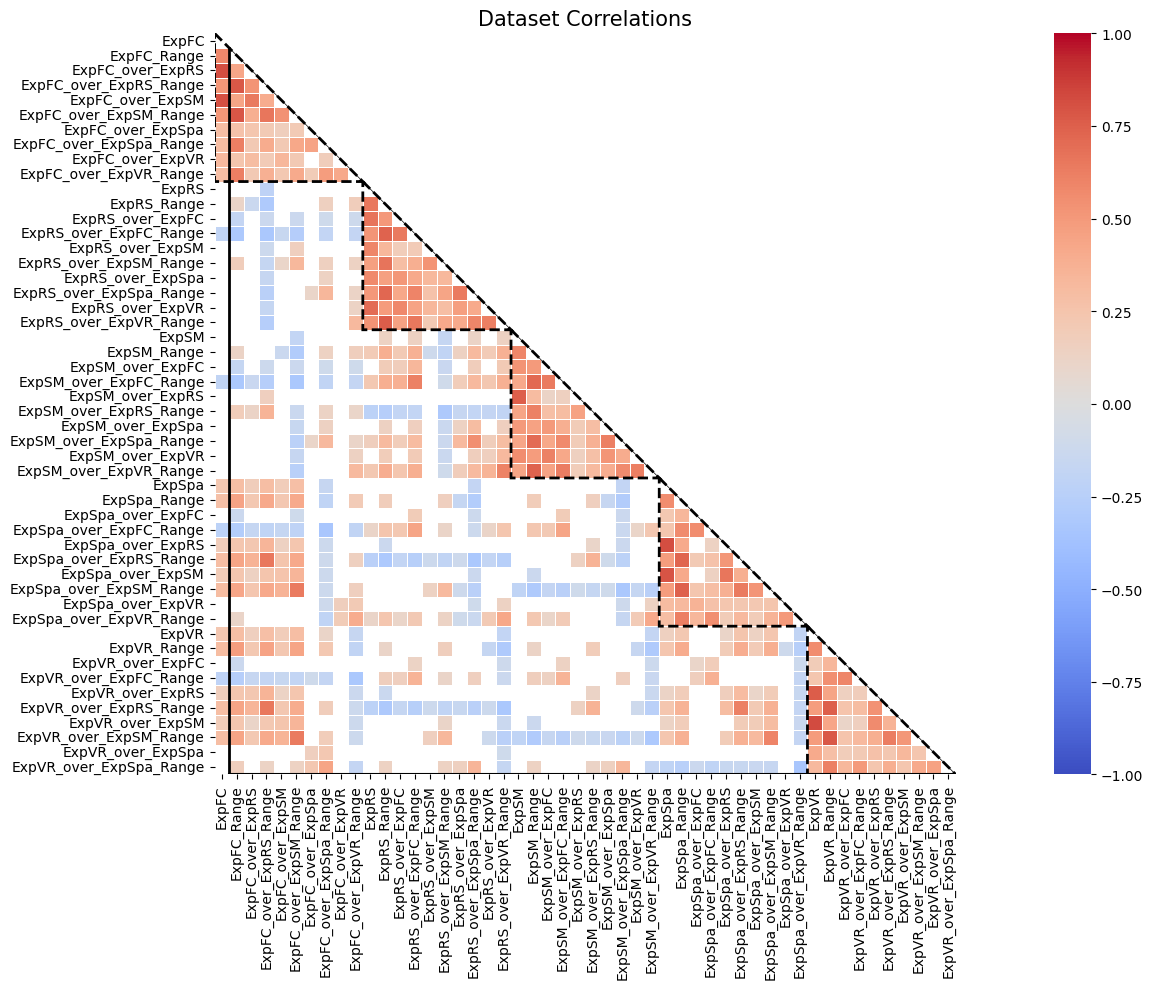

In [35]:
exp_feats = [feat for feat in train_df_CE.columns if 
            'ExpFC' in feat or 'ExpSM' in feat or 'ExpRS' in feat
             or 'ExpSpa' in feat or 'ExpVR' in feat in feat]
train_df_CE_enc = encode_and_correlation(train_df_CE[exp_feats])

From this plot, I select those features which Transported-correlation are painted (higher than the 0.1 threshold), with the following considerations:

- For the ranged-features, I only keep either the original version or the ranged-version, whichever is most Transported-correlated.

- For the ratio-features, in the case that inverse features <span style="font-weight:bold;">X_over_Y</span> and <span style="font-weight:bold;">Y_over_X</span> are both painted, I only keep the one most Transported-correlated.

The final selection is shown below, separated by families:

- <span style="font-weight:bold;">ExpFC_Range</span>, <span style="font-weight:bold;">ExpFC_over_ExpRS</span>, <span style="font-weight:bold;">ExpFC_over_ExpSM</span>, <span style="font-weight:bold;">ExpFC_over_ExpSpa</span>, <span style="font-weight:bold;">ExpFC_over_ExpVR</span>.

- <span style="font-weight:bold;">ExpSpa_Range</span>, <span style="font-weight:bold;">ExpSpa_over_ExpRS_Range</span>, <span style="font-weight:bold;">ExpSpa_over_ExpSM_Range</span>.
  
- <span style="font-weight:bold;">ExpVR_Range</span>, <span style="font-weight:bold;">ExpVR_over_ExpRS_Range</span>, <span style="font-weight:bold;">ExpVR_over_ExpSM_Range</span>

In [36]:
select_feats = ['ExpFC_Range','ExpFC_over_ExpRS','ExpFC_over_ExpSM',
                'ExpFC_over_ExpSpa','ExpFC_over_ExpVR','ExpSpa_Range',
                'ExpSpa_over_ExpRS_Range','ExpSpa_over_ExpSM_Range',
                'ExpVR_Range','ExpVR_over_ExpRS_Range','ExpVR_over_ExpSM_Range'
                ]
delete_feats = [feat for feat in test_df_CE.columns if 
                ('ExpFC' in feat or 'ExpRS' in feat or 'ExpSM' in feat or
                'ExpSpa' in feat or 'ExpVR' in feat) and (feat not in select_feats)
               ]
for feature in delete_feats:
    if feature in train_df_CE: # Just in case feature is already dropped
        train_df_CE = train_df_CE.drop(feature,axis=1)
        test_df_CE = test_df_CE.drop(feature,axis=1)

Expense-features are many and hard to visualize except for the ranged-versions. As an example, I plot two of them:

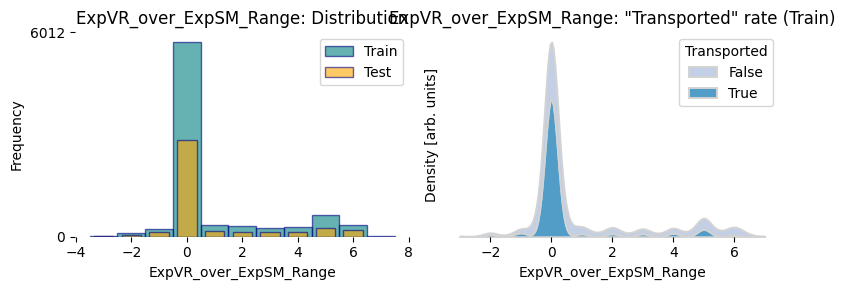

Explained ExpVR_over_ExpSM_Range values and Transported rates in training dataset:


ExpVR_over_ExpSM_Range,ExpVR_over_ExpSM,#Passengers,Transported_Rate[%]
-3,"[0.0001, 0.001)",17,52.910053
-2,"[0.001, 0.01)",118,51.690535
-1,"[0.01, 0.1)",231,41.989524
0,"[0.1, 1)",5726,60.565734
1,"[1, 10)",333,21.921264
2,"[10, 100)",323,23.528683
3,"[100, 1000)",269,27.508271
4,"[1000, 10000)",283,30.387619
5,"[10000, 100000)",625,29.599526
6,"[100000, 1000000)",357,11.764376


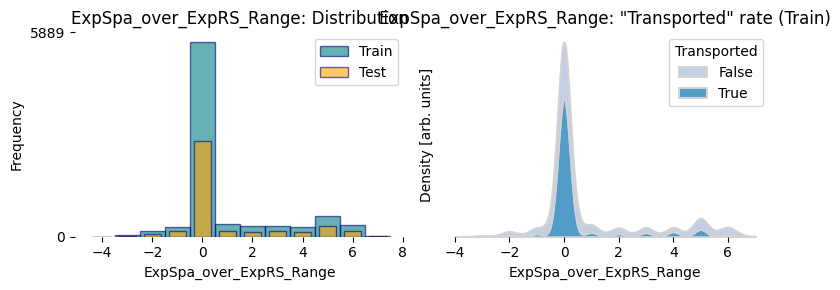

Explained ExpSpa_over_ExpRS_Range values and Transported rates in training dataset:


ExpSpa_over_ExpRS_Range,ExpSpa_over_ExpRS,#Passengers,Transported_Rate[%]
-4,"[1e-05, 0.0001)",1,0.000000
-3,"[0.0001, 0.001)",38,15.785320
-2,"[0.001, 0.01)",179,24.579632
-1,"[0.01, 0.1)",277,26.713837
0,"[0.1, 1)",5609,61.419038
1,"[1, 10)",377,28.381210
2,"[10, 100)",298,24.831381
3,"[100, 1000)",298,34.227039
4,"[1000, 10000)",291,42.266589
5,"[10000, 100000)",604,29.966391


In [37]:
# Plot distribution of values, survival rates and explain ranged-values:
feats = ['ExpVR_over_ExpSM_Range','ExpSpa_over_ExpRS_Range']
for feat in feats:
    fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(8, 3)) # Start figure
    bin_step = 1 if '_Range' in feat else None
    plot_dist_hist(train_df_CE,test_df_CE,feat,ax1,bin_step=bin_step)
    plot_KDE(train_df_CE,feat,ax2)     
    fig.tight_layout()
    plt.show()
    if '_Range' in feat:
        explain_range_values(train_df_CE,feat[:-6])

<a id="Feature_engineering_corr3"></a>
### <span style="color:teal;font-weight:bold;">Correlations III (all features)</span>

Let's visualize the correlations for all features:

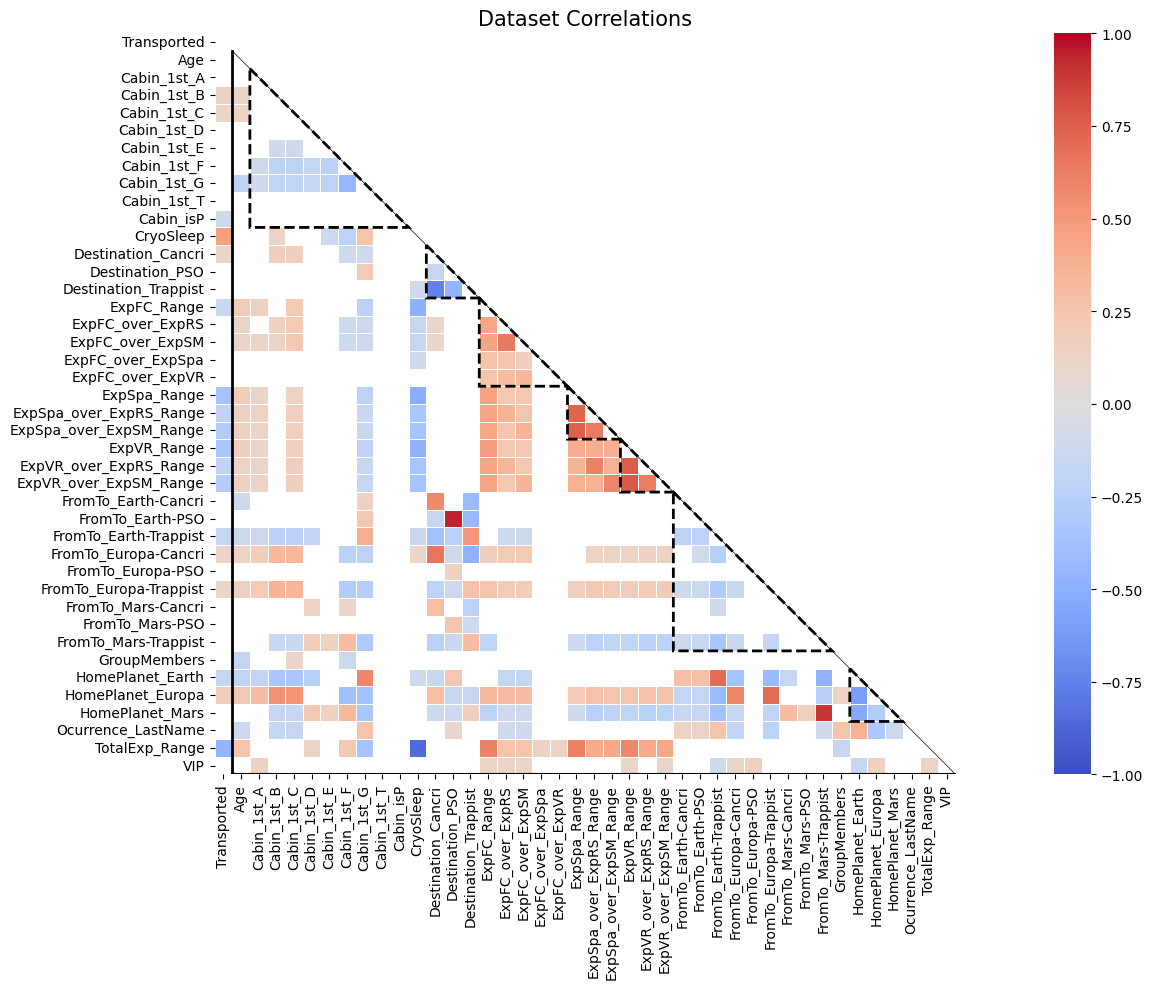

In [38]:
# Encode features and select subset:
train_df_CE_enc = encode_and_correlation(train_df_CE) # Training dataset (to be plotted)
test_df_CE_enc = encode_and_correlation(test_df_CE,plot_corr=False) # Testing dataset (not plotted)

<a id="Submission_results"></a>
# <span style="color:teal;font-weight:bold;">Submission results</span>

As the final stage of this notebook, <span style="font-weight:bold;">after engineering features I will test the improved dataset and make a few submissions</span>. As an internal benchmark, <span style="font-weight:bold;">the best score that I got using the original dataset was 0.79635</span> (see <a href="https://www.kaggle.com/code/fertmeneses/spaceship-titanic-getting-familiar/edit/run/191353629">Spaceship Titanic 🏁 Getting familiar</a>).

Since some Machine Learning models don't accept NaN values, I correct the missing values with the following criteria:

* Numeric features: assign mean value.

* Non-numeric features: assign most frequent value.

In [39]:
# Simple correction for dataset:
def simple_data_correction(df,target_col='Transported'):
    """
    Corrects missing values using the average value for numeric features
    or most frequent value for non-numeric features.
    --- Inputs ---
    {df} [Dataframe]: Dataframe to be corrected.
    {target_col} [String]: Target column in the dataframe (won't be corrected)
    --- Outputs ---
    {df_corrected} [Dataframe]: Corrected Dataframe.
    """
    df_corrected = df.copy()
    # Determine column types:
    col_numeric = [col for col in df.columns if 
                   df[col].dtypes != 'object' and col!=target_col]
    col_object = [col for col in df.columns if 
                  col not in col_numeric and col!=target_col]
    # Correct numeric columns:
    for col in col_numeric:
        df_corrected[col] = df[col].fillna(value=df[col].mean())
    # Correct non-numeric columns:
    for col in col_object:
        most_freq = df[col].value_counts(sort=True).index[0]
        df_corrected[col] = df[col].fillna(value=most_freq)
    return df_corrected

# Define models:
import numpy as np
from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Train ML models and export the submission file:
def train_submit_ML(model,train_df,test_df):
    """
    Trains a ML model, and saves the submission file.
    --- Inputs ---
    {model} [Machine Learning model]: ML model to be trained.
    {train_df} [Dataframe]: Training dataset, it must contain the
    columns "PassengerId" and "Transported".
    {test_df} [Dataframe]: Testing dataset, it must contain the
    column "PassengerId".
    --- Outputs ---
    {train_score} [Float]: Training score.
    """
    # Extract PassengerId and Transported columns, if applicable:
    passID_train = train_df['PassengerId']
    passID_test = test_df['PassengerId']
    y_train = train_df['Transported']
    x_train = train_df.drop(['PassengerId','Transported'],axis=1)
    x_test = test_df.drop('PassengerId',axis=1)
    # Initialize model with fixed seed if possible:
    if 'random_state' in dir(model):
        model.random_state = 0 
    # Train the model:
    model.fit(x_train,y_train)
    train_score = model.score(x_train,y_train) # Get training score
    # Make submission:
    preds = model.predict(x_test)
    preds = preds.astype(bool) # Ensure the values are boolean
    df_subm = pd.DataFrame({
        "PassengerId": passID_test,
        "Transported": preds
    }).to_csv('submission.csv', index=False)
    # Final output and message:
    print("Training score:", np.round(train_score,4))
    print("Submission file ready.")
    return train_score, preds

In [43]:
# ML Options:
# RandomForestClassifier(n_estimators=100, max_depth=5)
# GradientBoostingClassifier(n_estimators=100, max_depth=3)
# XGBClassifier(n_estimators=100, max_depth=3)

# Features options:
# CE: ALL features (Original + Engineered)
# SE: Original + Engineered based on single-features

# Select subset of features:
feats = 'SE'

# Prepare datasets:
if feats == 'CE':
    df_subm_train = pd.concat([train_ID,simple_data_correction(train_df_CE_enc)],axis=1)
    df_subm_test = pd.concat([test_ID,simple_data_correction(test_df_CE_enc)],axis=1)
elif feats == 'SE':
    df_subm_train = pd.concat([train_ID,simple_data_correction(train_df_SE_enc)],axis=1)
    df_subm_test = pd.concat([test_ID,simple_data_correction(test_df_SE_enc)],axis=1)
# Define and train simple model:   
model = GradientBoostingClassifier(n_estimators=300, max_depth=3)
train_score, preds = train_submit_ML(model,df_subm_train,df_subm_test)

Training score: 0.8392
Submission file ready.


<a id="Conclusions"></a>
# <span style="color:teal;font-weight:bold;">Conclusions</span>

Xxxx